# prelim modeling


In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

In [35]:
#pull in data

In [36]:
posts = pd.read_csv('../data/satirevsreal.csv')

In [37]:
posts.head()

,text,label,text_length,text_word_count,compound,neg,neu,pos
0,Planned Parenthood Mounts Giant IUD Atop Headquarters To Harness Sperm-Killing Power Of Lightning,1.0,97.0,13.0,0.0000,0.000,1.000,0.000
1,Teachers React To Yet Another School Shooting,1.0,45.0,7.0,0.0000,0.000,1.000,0.000
2,Children Of All Ages Delighted By Enslavement Of Topsy The Elephant,1.0,67.0,11.0,0.5106,0.000,0.752,0.248
3,Texas Passes Mandatory 24-Hour Waiting Period Before Police Can Engage Active Shooters,1.0,86.0,12.0,0.6597,0.000,0.584,0.416
4,School Practices Drill For When There’s Not An Active Shooter,1.0,61.0,10.0,-0.3089,0.201,0.799,0.000


In [39]:
posts.head()

,text,label,text_length,text_word_count,compound,neg,neu,pos
0,Planned Parenthood Mounts Giant IUD Atop Headquarters To Harness Sperm-Killing Power Of Lightning,1.0,97.0,13.0,0.0000,0.000,1.000,0.000
1,Teachers React To Yet Another School Shooting,1.0,45.0,7.0,0.0000,0.000,1.000,0.000
2,Children Of All Ages Delighted By Enslavement Of Topsy The Elephant,1.0,67.0,11.0,0.5106,0.000,0.752,0.248
3,Texas Passes Mandatory 24-Hour Waiting Period Before Police Can Engage Active Shooters,1.0,86.0,12.0,0.6597,0.000,0.584,0.416
4,School Practices Drill For When There’s Not An Active Shooter,1.0,61.0,10.0,-0.3089,0.201,0.799,0.000


# Modeling Prep

#### Set up X and y

In [41]:
X = posts[['text', 'compound', 'neg', 'pos', 'neu', 'text_length', 'text_word_count']]
y = posts['label']

In [42]:
X.shape

(37185, 7)

In [43]:
#check for balanced classes & baseline

y.value_counts(normalize = True)

0.0    0.655587
1.0    0.344413
Name: label, dtype: float64

#### train test split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

### tfidfVectorizer

In [45]:
tvec = TfidfVectorizer(stop_words = 'english', max_features = 3000, ngram_range = (1, 5))

X_train_cv = tvec.fit_transform(X_train['text'])
X_test_cv = tvec.transform(X_test['text'])

#### Create new dataframes for training and test text

In [47]:
df_X_train = pd.DataFrame(X_train_cv.todense(), columns = cvec.get_feature_names())

In [48]:
df_X_test = pd.DataFrame(X_test_cv.todense(), columns = cvec.get_feature_names())

#### Reset Indices

In [49]:
df_X_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
df_X_test.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace=True)

#### Add sentiment scores back to text data. merge on index, drop 'text' column 

In [50]:
X_train_all = pd.concat([df_X_train, X_train], axis =1 )

In [51]:
X_test_all = pd.concat([df_X_test, X_test], axis = 1)

In [52]:
X_train_all.drop(columns = 'text', inplace = True)
X_test_all.drop(columns = 'text', inplace = True)

#### Checking all my data dimensions

In [53]:
X_train_all.shape, X_test_all.shape

((27888, 3005), (9297, 3005))

In [54]:
y_train.shape, y_test.shape

((27888,), (9297,))

### Prelim Modeling Time

- For now looking at more interpretable models:
    - Logistic Regression without regularization for interpretable coefficients
    - Decision Tree Classifier for fairly interpretable feature importance scores
    - Random Forest Classifier for somewhat interpretable feature importance scores and hopefully better predictions
    
    - Will tune with RandomizedSearchCV rather than GridsearchCV to speed up tuning process

In [55]:
# Instaniate logistic regression

In [56]:
logreg = LogisticRegression(penalty = 'none', max_iter = 10000)

In [ ]:
logreg.fit(X_train_all, y_train)

In [37]:
logreg.score(X_train_all, y_train), logreg.score(X_test_all, y_test)

(0.8641351118760757, 0.8016564483166613)

In [38]:
logreg.coef_

array([[-1.0834222 ,  0.37466843, -2.32381975, ..., -0.86227113,
         0.02484108, -0.06113521]])

In [41]:
coefs = pd.DataFrame({'variable':X_train_all.columns,
                            'coef':logreg.coef_.squeeze(),
                     'abs coef': np.abs(logreg.coef_.squeeze())})

coefs.sort_values('abs coef', inplace=True, ascending=False)

coefs.head(30)

,variable,coef,abs coef
1094,ftw,14.648608,14.648608
63,according,-14.546780,14.546780
1231,heartwarming,13.730099,13.730099
2983,xpost,-13.575782,13.575782
1901,patriothole,13.109059,13.109059
1382,jailed,-12.771227,12.771227
78,ad_1,-12.714645,12.714645
692,currently,12.666350,12.666350
343,boris,-11.994531,11.994531
1032,fined,-11.981576,11.981576


### Logreg Confusion Matrix 

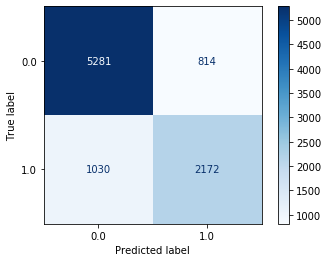

In [43]:
# # Get predictions
preds_logreg = logreg.predict(X_test_all)

# # Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_logreg).ravel()

plot_confusion_matrix(logreg, X_test_all, y_test, cmap='Blues', values_format='d');


In [44]:
from sklearn.metrics import recall_score

recall_score(y_test, preds_logreg)

0.6783260462211118

### RandomForest

In [45]:
rfc = RandomForestClassifier()

In [46]:
rfc.fit(X_train_all, y_train)

RandomForestClassifier()

In [137]:
rfc.score(X_train_all, y_train), rfc.score(X_test_all, y_test)

(0.9973961998592541, 0.7745408486383787)

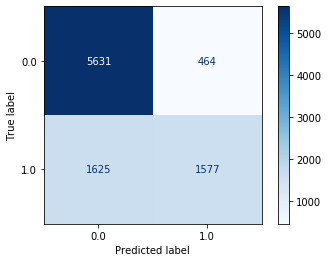

In [47]:
# # Get predictions
preds_rfc = rfc.predict(X_test_all)

# # Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_rfc).ravel()

plot_confusion_matrix(rfc, X_test_all, y_test, cmap='Blues', values_format='d');


In [48]:
recall_score(y_test, preds_rfc)

0.4925046845721424

In [56]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [57]:
params = {'max_depth': [20, 30, 40],
          'n_estimators': [100, 200, 300],
          'min_samples_leaf': [3, 5, 7],
          'min_samples_split': [2, 3, 5]    
}

In [58]:
random = RandomizedSearchCV(rfc, params, cv = 3)
random.fit(X_train_all, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [20, 30, 40],
                                        'min_samples_leaf': [3, 5, 7],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [100, 200, 300]})

In [59]:
random.score(X_train_all, y_train), random.score(X_test_all, y_test)

(0.763088066551922, 0.7415295256534365)

In [60]:
random.best_params_

# {'n_estimators': 100,
#  'min_samples_split': 3,
#  'min_samples_leaf': 3,
#  'max_depth': 40}

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_depth': 40}

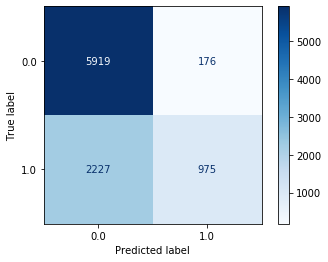

In [61]:
# Get predictions
preds_rfc = random.predict(X_test_all)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_rfc).ravel()

plot_confusion_matrix(random, X_test_all, y_test, cmap='Blues', values_format='d');


In [65]:
recall_score(y_test, preds_rfc)

0.30449718925671454

In [66]:
random.best_params_

# {'n_estimators': 225,
#  'min_samples_split': 3,
#  'min_samples_leaf': 5,
#  'max_depth': 40}

# best so far

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_depth': 40}

In [67]:
###tune this

In [68]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.9711238720262511


In [70]:
# Let's create a dataframe called pred_df that contains:
# 1. The true values of our test set.
# 2. The predicted probabilities based on our model.

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': random.predict_proba(X_test_all)[:,1]})

pred_df.head()

,true_values,pred_probs
28563,0.0,0.278412
25800,1.0,0.421949
12848,0.0,0.249034
31720,1.0,0.386326
16775,0.0,0.271712


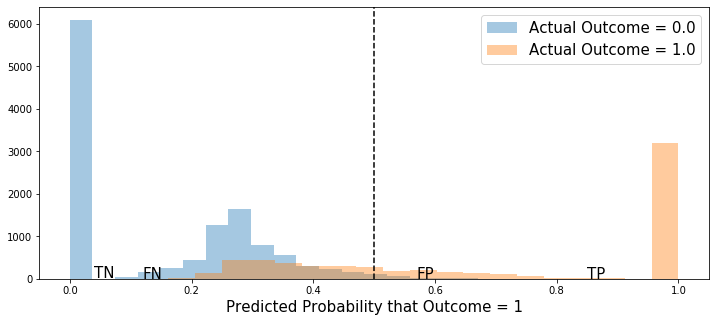

In [74]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.5, color = 'black', linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15), s = 'TN', size = 15)
plt.annotate(xy = (0.12, 0), s = 'FN', size = 15)
plt.annotate(xy = (0.85, 1), s = 'TP', size = 15)
plt.annotate(xy = (0.57, 1), s = 'FP', size = 15)

plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 15)
plt.legend(fontsize = 15);

In [75]:
###consider shifting the threshold to .35-.4

In [77]:
from sklearn.metrics import plot_roc_curve

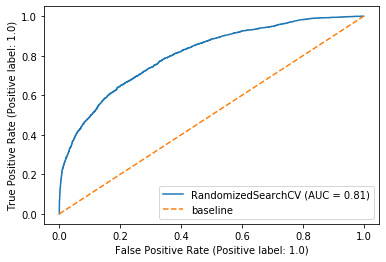

In [78]:
plot_roc_curve(random, X_test_all, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [79]:
f = {'Column Name':X_train_all.columns,'Feature Importance':rfc.feature_importances_}
rfc_fi = pd.DataFrame(f)

rfc_fi.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
3003,text_length,0.048440
3004,text_word_count,0.035697
2999,compound,0.017261
3002,neu,0.015205
3000,neg,0.013484
3001,pos,0.011845
1837,onion,0.011705
1528,life,0.011599
1752,nation,0.008819
1419,just,0.007660
